### Metrics Change Plot with BSA normalized HADDOCK scores

BSA normalized HADDOCK scores were added to the plot, colored in black. 

In [2]:
import pathlib
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

#import numpy as np
rootdir = pathlib.Path('.').resolve(strict=True)
outputdir = rootdir.parents [1] / 'files/output_files'

# import SARS_CoV_2_RBD_ACE2_benchmarking_dataset.csv
Sorted_BSA_Normalized = pd.read_csv(outputdir / 'Sorted_BSA_Normalized_SARS-CoV-2-RBD_ACE2_benchmarking_dataset.csv', delimiter=',')
#rename BSA normalized column to make proper for the prediction status function
Sorted_BSA_Normalized = Sorted_BSA_Normalized.rename(columns = {"DDG_BSA_Normalized":"BSAnorm_haddock-ddg"})


In [3]:
pd.set_option('mode.chained_assignment', None)
def prediction_status(df):
    columns=df.columns
    ddg_columns=columns[columns.str.contains('ddg')]

    for i in ddg_columns:
        enriched = df[df['exp_binding']>0]
        depleted = df[df['exp_binding']<0]

        condition_enr = [
                (enriched.loc[:, [f'{i}']] < 0),
                (enriched.loc[:, [f'{i}']] >= 0)]

        value_enr = ['success', 'failure']
        enriched.loc[:,[f'{i}-prediction']] = np.select(condition_enr, value_enr)

        condition_dep = [
                (depleted.loc[:, [f'{i}']] <= 0),
                (depleted.loc[:, [f'{i}']] > 0)]

        value_dep = ['failure', 'success']
        depleted.loc[:,[f'{i}-prediction']] = np.select(condition_dep, value_dep)
        df=pd.concat([enriched, depleted])
    return (df)



In [4]:
def volume_change(df):
    volume = dict(A=0.05702, R=0.58946, N=0.22972, D=0.21051, C=0.14907, Q=0.34861, E=0.32837, G=0.00279, H=0.37694, I=0.37671,
              L=0.37876, K=0.45363, M=0.38872, F=0.55298, P=0.2279, S=0.09204, T=0.19341, W=0.79351, Y=0.6115, V=0.25674)
    
    list_caseid = df[['#case_id']].values.tolist()

    volume_change = []
    for i in list_caseid:
        mutant_resi= i[0][-1]
        wt_resi= i[0][0]
        #volume dictionary contains vdW volume of amino acids
        vdW_mutant_resi =volume[mutant_resi]
        vdW_wt_resi=volume[wt_resi]
        #2 place after the decimal
        delta_vdW=round(vdW_mutant_resi-vdW_wt_resi,2)
        volume_change.append(delta_vdW)

    volume_change_column=pd.DataFrame(volume_change, columns=['volume_change'])
    df = pd.concat([df,volume_change_column], axis=1)
    return(df)

def hydrophobicity_change(df):
    hydrophobicity = dict(A=0.62, R=-2.53, N=-0.78, D=-0.90, C=0.29, Q=-0.85, E=-0.74, G=0.48, H=-0.40, I=1.38,
                L=1.06, K=-1.50, M=0.64, F=1.19, P=0.12, S=-0.18, T=-0.05, W=0.81, Y=0.26, V=1.08) 

    list_caseid = df[['#case_id']].values.tolist()

    hydrophobicity_change = []
    for i in list_caseid:
        mutant_resi= i[0][-1]
        wt_resi= i[0][0]
        #hydrophobicity dictionary contains hydrophobicity value of amino acids
        hyd_mutant_resi =hydrophobicity[mutant_resi]
        hyd_wt_resi=hydrophobicity[wt_resi]
        #2 place after the decimal
        delta_hyd=round(hyd_mutant_resi-hyd_wt_resi,2)
        hydrophobicity_change.append(delta_hyd)
   
    hydrophobicity_change_column=pd.DataFrame(hydrophobicity_change, columns=['hydrophobicity_change'])
    df = pd.concat([df,hydrophobicity_change_column], axis=1)
    return(df)

def flexibility_change(df):
    flexibility = dict(A=1, R=81, N=3, D=3, C=3, Q=9, E=9, G=1, H=3, I=9,
                L=9, K=81, M=27, F=3, P=2, S=3, T=3, W=3, Y=3, V=3) 

    list_caseid = df[['#case_id']].values.tolist()

    flexibility_change = []
    for i in list_caseid:
        mutant_resi= i[0][-1]
        wt_resi= i[0][0]
        #flexibility dictionary contains hydrophobicity value of amino acids
        flex_mutant_resi =flexibility[mutant_resi]
        flex_wt_resi=flexibility[wt_resi]
        #2 place after the decimal
        delta_flex=round(flex_mutant_resi-flex_wt_resi,2)
        flexibility_change.append(delta_flex)
   
    flexibility_change_column=pd.DataFrame(flexibility_change, columns=['flexibility_change'])
    df = pd.concat([df,flexibility_change_column], axis=1)
    return(df)


main_dataset = prediction_status(flexibility_change(hydrophobicity_change(volume_change(Sorted_BSA_Normalized))))

In [5]:
# performances
def performance_calculation(df):
    """
    This fuction calculates performance of predictors from input dataset by using <xx>-prediction columns. 
    These columns represent the binary prediction status of predictor -success or failure.
    This function counts success cases and calculates the performance of predictor.
    """
    columns=df.columns
    # get <xx>-prediction columns as a list
    prediction_columns=columns[columns.str.contains('prediction')]
    performances = []
    for i in prediction_columns:
        predictor_name = f'{i}'
        success_rate= [f'{predictor_name}', round(sum(df[f'{i}'].str.count("success")/len(df['#case_id'])*100),2)]
        performances.append(success_rate)
    performances = pd.DataFrame(performances)
    
    return performances

# Total performances of predictors were calculated. 
# Additionally performance calculation according to mutation type(Enriched, Depleted) and protein type (ACE2, RBD) were builded.  

Total=performance_calculation(main_dataset)
Enriched=performance_calculation(main_dataset[main_dataset['exp_binding']>0])
Depleted=performance_calculation(main_dataset[main_dataset['exp_binding']<0])
ACE2=performance_calculation(main_dataset[main_dataset.protein =='ACE2'])
ACE2_Enriched=performance_calculation(main_dataset[(main_dataset.protein == 'ACE2') & (main_dataset['exp_binding'] >0)])
ACE2_Depleted=performance_calculation(main_dataset[(main_dataset.protein == 'ACE2') & (main_dataset['exp_binding'] <0)])
RBD=performance_calculation(main_dataset[main_dataset.protein =='RBD'])
RBD_Enriched=performance_calculation(main_dataset[(main_dataset.protein == 'RBD') & (main_dataset['exp_binding'] >0)])
RBD_Depleted=performance_calculation(main_dataset[(main_dataset.protein == 'RBD') & (main_dataset['exp_binding'] <0)])

main_performance_table = pd.concat([Total,Enriched[1], Depleted[1], ACE2[1], ACE2_Enriched[1], ACE2_Depleted[1], RBD[1], RBD_Enriched[1], RBD_Depleted[1]], axis=1)
main_performance_table.columns=['Predictors', 'Total', 'Enriched', 'Depleted', 'ACE2', 'ACE2 Enriched', 'ACE2 Depleted', 'RBD', 'RBD Enriched', 'RBD Depleted']
main_performance_table['Predictors'] = ['HADDOCK', 'FoldX', 'FoldXwater', 'EvoEF1', 'MutaBind2', 'SSIPe', 'BSAnorm-HADDOCK']
main_performance_table.set_index('Predictors')

,Total,Enriched,Depleted,ACE2,ACE2 Enriched,ACE2 Depleted,RBD,RBD Enriched,RBD Depleted
Predictors,,,,,,,,,
HADDOCK,53.99,51.91,56.06,55.87,46.07,65.56,50.00,64.29,35.71
FoldX,63.88,51.15,76.52,62.01,47.19,76.67,67.86,59.52,76.19
FoldXwater,62.74,51.15,74.24,60.89,47.19,74.44,66.67,59.52,73.81
EvoEF1,57.41,48.85,65.91,57.54,48.31,66.67,57.14,50.00,64.29
MutaBind2,55.51,15.27,95.45,53.07,7.87,97.78,60.71,30.95,90.48
SSIPe,55.51,21.37,89.39,51.40,14.61,87.78,64.29,35.71,92.86
BSAnorm-HADDOCK,55.13,91.60,18.94,53.07,89.89,16.67,59.52,95.24,23.81


In [6]:
def vol_hyd_flex_fig_dataset(df, prediction_status):
    predictors_data = []
    predictor_list=['haddock', 'foldx', 'foldxwater', 'evoef1', 'mutabind2', 'ssipe', 'BSAnorm_haddock' ]
    for i in predictor_list:        
        predictor= df[df[f'{i}-ddg-prediction'].str.contains(prediction_status)]
        predictor=predictor.copy()
        predictor['predictor']=i.upper()
        predictors_data.append(predictor)        
    experimental = df.copy()
    experimental['predictor'] = "Experimental"
        
    dataset = pd.concat([predictors_data[0], predictors_data[1], predictors_data[2], predictors_data[3], predictors_data[4], predictors_data[5], predictors_data[6], experimental], axis=0)
    return(dataset)
# define enriched and depleted dataset
enriched = main_dataset[main_dataset.exp_binding >0 ]
depleted = main_dataset[main_dataset.exp_binding <0 ]

# datasets for plot preperation
Enriched_Success_dataset = vol_hyd_flex_fig_dataset(enriched, prediction_status = "success").sort_values("predictor")
Enriched_Failure_dataset = vol_hyd_flex_fig_dataset(enriched, prediction_status = "failure").sort_values("predictor")
Depleted_Success_dataset = vol_hyd_flex_fig_dataset(depleted, prediction_status = "success").sort_values("predictor")
Depleted_Failure_dataset = vol_hyd_flex_fig_dataset(depleted, prediction_status = "failure").sort_values("predictor")

Text(0.5, 1.0, 'Depleted Failure')

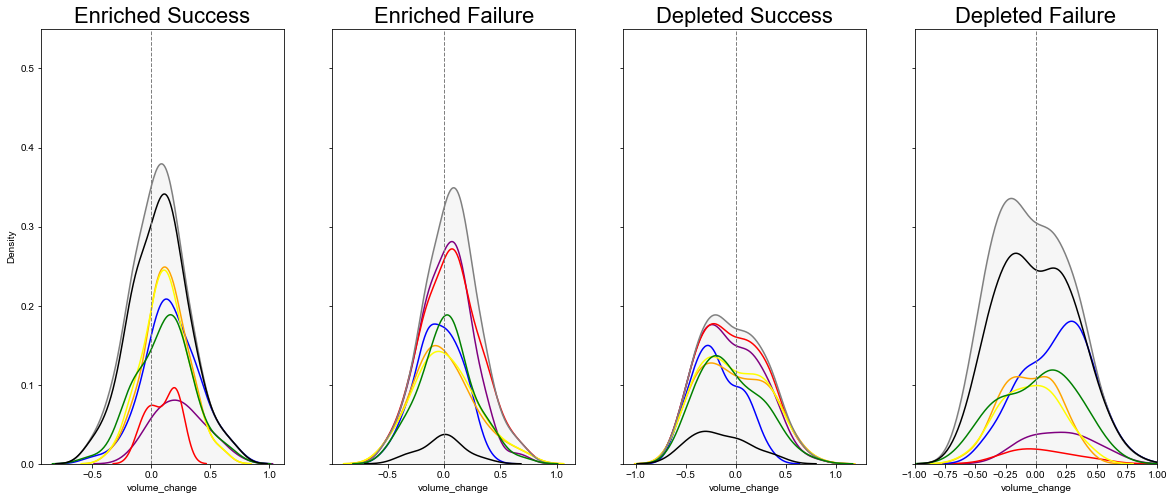

In [7]:
def kdeplot(df,quantity,limit_y,limit_x, subplot):
    sns.set_style('white')
    color=["black","green", "gray", "yellow","orange", "blue", "red", "purple"]
    g = sns.kdeplot(data=df, x=quantity, hue="predictor",palette=color, legend=False, ax=subplot)
    x = g.lines[-3].get_xdata()
    y = g.lines[-3].get_ydata()
    g.fill_between(x, 0, y, color='gray', alpha=0.07)
    g.axvline(0, color = 'gray', linestyle = 'dashed', linewidth = 1)
    plt.ylim(limit_y)
    plt.xlim(limit_x)

fig1,axes=plt.subplots(1,4, sharey=True, figsize=(20,8))
# Volume
kdeplot(Enriched_Success_dataset, quantity ='volume_change',limit_y=(0,0.55), limit_x=(-1,1), subplot=axes[0])
kdeplot(Enriched_Failure_dataset, quantity ='volume_change',limit_y=(0,0.55), limit_x=(-1,1), subplot=axes[1])
kdeplot(Depleted_Success_dataset, quantity ='volume_change',limit_y=(0,0.55), limit_x=(-1,1), subplot=axes[2])
kdeplot(Depleted_Failure_dataset, quantity ='volume_change',limit_y=(0,0.55), limit_x=(-1,1), subplot=axes[3])

axes[0].set_title('Enriched Success', size=22)
axes[1].set_title('Enriched Failure', size=22)
axes[2].set_title('Depleted Success', size=22)
axes[3].set_title('Depleted Failure', size=22)

Text(0.5, 1.0, 'Depleted Failure')

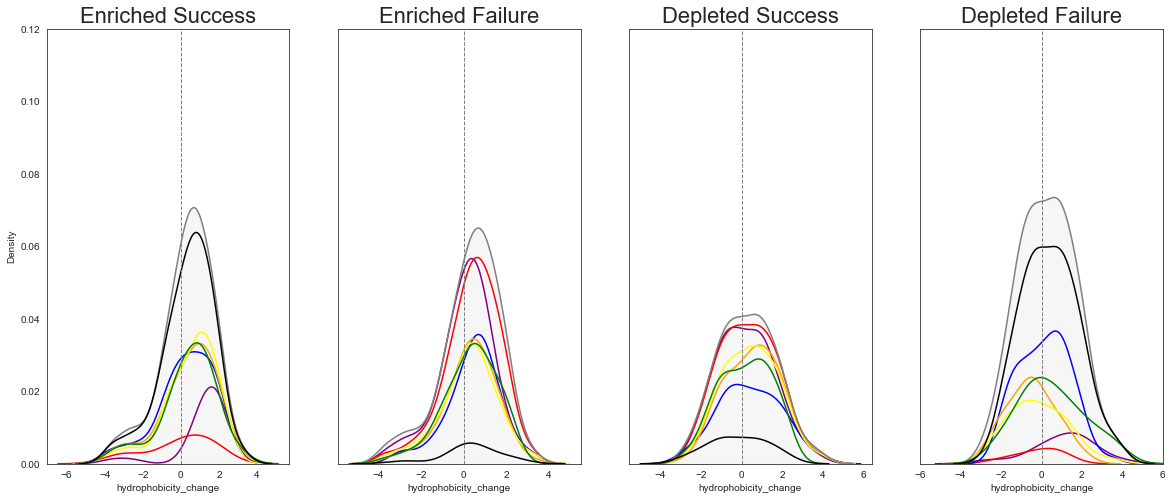

In [8]:
fig2,axes=plt.subplots(1,4, sharey=True,  figsize=(20,8))
# Hydrophobicity
kdeplot(Enriched_Success_dataset, quantity ='hydrophobicity_change',limit_y=(0,0.12), limit_x=(-6,6), subplot=axes[0])
kdeplot(Enriched_Failure_dataset, quantity ='hydrophobicity_change',limit_y=(0,0.12), limit_x=(-6,6), subplot=axes[1])
kdeplot(Depleted_Success_dataset, quantity ='hydrophobicity_change',limit_y=(0,0.12), limit_x=(-6,6), subplot=axes[2])
kdeplot(Depleted_Failure_dataset, quantity ='hydrophobicity_change',limit_y=(0,0.12), limit_x=(-6,6), subplot=axes[3])

axes[0].set_title('Enriched Success', size=22)
axes[1].set_title('Enriched Failure', size=22)
axes[2].set_title('Depleted Success', size=22)
axes[3].set_title('Depleted Failure', size=22)

Text(0.5, 1.0, 'Depleted Failure')

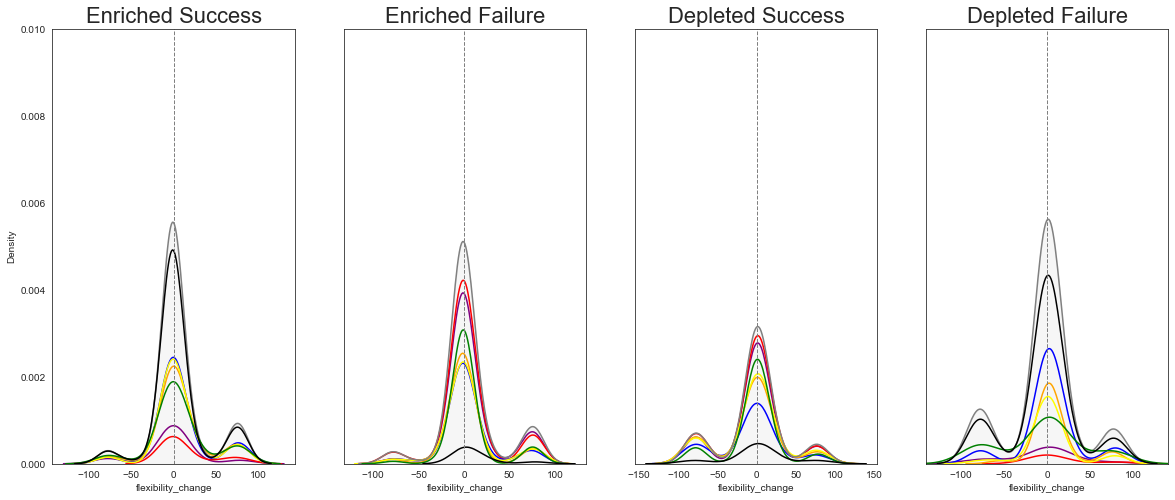

In [9]:
fig3,axes=plt.subplots(1,4, sharey=True,  figsize=(20,8))
# Flexibity
kdeplot(Enriched_Success_dataset, quantity ='flexibility_change',limit_y=(0,0.01), limit_x=(-140,140), subplot=axes[0])
kdeplot(Enriched_Failure_dataset, quantity ='flexibility_change',limit_y=(0,0.01), limit_x=(-140,140), subplot=axes[1])
kdeplot(Depleted_Success_dataset, quantity ='flexibility_change',limit_y=(0,0.01), limit_x=(-140,140), subplot=axes[2])
kdeplot(Depleted_Failure_dataset, quantity ='flexibility_change',limit_y=(0,0.01), limit_x=(-140,140), subplot=axes[3])

axes[0].set_title('Enriched Success', size=22)
axes[1].set_title('Enriched Failure', size=22)
axes[2].set_title('Depleted Success', size=22)
axes[3].set_title('Depleted Failure', size=22)

In [10]:
figures=[fig1,fig2,fig3]
with PdfPages(outputdir / 'BSAnormHADDOCK-Figures.pdf') as pdf:
    for i in figures:
        pdf.savefig(i)

In [49]:
metrics = ['volume_change', 'hydrophobicity_change', 'flexibility_change']
predictors = ['HADDOCK', 'FOLDX', 'FOLDXWATER', 'EVOEF1', 'MUTABIND2', 'SSIPE', 'BSANORM_HADDOCK']
success_rates = []
table = []
for i in metrics:
    Enriched_Success_dataset_bigger_than_0 = Enriched_Success_dataset[Enriched_Success_dataset[i] >= 0]
    Depleted_Success_dataset_bigger_than_0 = Depleted_Success_dataset[Depleted_Success_dataset[i] >= 0]
    for i in predictors:
        enr=round(len(Enriched_Success_dataset_bigger_than_0[Enriched_Success_dataset_bigger_than_0['predictor']==f'{i}'])/len(Enriched_Success_dataset_bigger_than_0[Enriched_Success_dataset_bigger_than_0['predictor']=="Experimental"])*100, 0)
        dep=round(len(Depleted_Success_dataset_bigger_than_0[Depleted_Success_dataset_bigger_than_0['predictor']==f'{i}'])/len(Depleted_Success_dataset_bigger_than_0[Depleted_Success_dataset_bigger_than_0['predictor']=="Experimental"])*100, 0)
        success_rates.append([enr, dep, enr-dep])

x = pd.DataFrame(success_rates, columns=['Enriched success', "Depleted success","∆Success rate"], index=['HADDOCK', 'FoldX', 'FoldXwater', 'EvoEF1','MutaBind2', 'SSIPe','BSAnorm_HADDOCK', 'HADDOCK', 'FoldX', 'FoldXwater', 'EvoEF1','MutaBind2', 'SSIPe', 'BSAnorm_HADDOCK','HADDOCK', 'FoldX', 'FoldXwater', 'EvoEF1','MutaBind2', 'SSIPe', 'BSAnorm_HADDOCK'])
Volume = x[0:7]
Hydrophobicity = x[7:13]
Flexibility = x[13:19]

x = pd.concat([Volume, Hydrophobicity, Flexibility],keys=["Volume", "Hydrophobicity", "Flexibility"])
x = x.style.format('{:.0f}')
x.set_table_styles([{'selector' : '','props' : [('border','1px solid black')]}])
cm = sns.diverging_palette(220, 20, as_cmap=True)
table = x.background_gradient(cmap=cm, subset=["∆Success rate"], axis=None, vmin=-100, vmax=100 )
table = table.set_properties(**{'font-size': '13pt', 'font-family': 'Helvatica'})
table